# Showcasing the results
1. Estimation performance
2. Hypothesis testing performance

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import scipy
import json
import pandas as pd
import seaborn as sns
import os
import admix
import scipy.stats
import pickle
from admix_genet_cor import hdi
import string

import matplotlib

matplotlib.rcParams["font.family"] = ["Liberation Sans"]

In [2]:
with open("cache/dict_res.pkl", "rb") as f:
    dict_res = pickle.load(f)

In [3]:
dict_loglik = dict_res["loglik"]
df_plot = []
pcausal = 0.001
for hsq in [0.1, 0.25, 0.5]:
    for cor in [0.9, 0.95, 1.0]:
        for grm_prefix in ["hm3", "imputed"]:
            loglik = dict_loglik[
                (
                    f"hsq-{hsq}-pcausal-{pcausal}-cor-{cor}-hermodel-mafukb",
                    f"{grm_prefix}.mafukb.005",
                )
            ]
            mode = loglik.argmax() / 1000
            lower_ci, upper_ci = hdi(np.linspace(0, 1, 1001), loglik)
            df_plot.append([hsq, pcausal, cor, grm_prefix, mode, lower_ci, upper_ci])
df_plot = pd.DataFrame(
    df_plot, columns=["hsq", "pcausal", "cor", "snpset", "mode", "lower_ci", "upper_ci"]
)

# Plot the estimate

In [4]:
for snpset in ["imputed", "hm3"]:
    print(f"## {snpset}")
    df_tmp = df_plot[df_plot.snpset == snpset].copy()
    df_tmp["relative_bias"] = (df_tmp["mode"] - df_tmp["cor"]) / df_tmp["cor"]
    display(df_tmp)
    print(f"Average relative bias = {df_tmp['relative_bias'].mean() * 100:.2g}%")

    print("Most biased parameter")
    display(df_tmp.loc[df_tmp["relative_bias"].abs().idxmax()])

## imputed


,hsq,pcausal,cor,snpset,mode,lower_ci,upper_ci,relative_bias
1,0.10,0.001,0.90,imputed,0.904,0.885,0.920,0.004444
3,0.10,0.001,0.95,imputed,0.932,0.915,0.948,-0.018947
5,0.10,0.001,1.00,imputed,1.000,0.989,1.000,0.000000
7,0.25,0.001,0.90,imputed,0.892,0.883,0.902,-0.008889
9,0.25,0.001,0.95,imputed,0.943,0.935,0.951,-0.007368
11,0.25,0.001,1.00,imputed,1.000,0.996,1.000,0.000000
13,0.50,0.001,0.90,imputed,0.893,0.887,0.899,-0.007778
15,0.50,0.001,0.95,imputed,0.951,0.946,0.956,0.001053
17,0.50,0.001,1.00,imputed,1.000,0.998,1.000,0.000000


Average relative bias = -0.42%
Most biased parameter


hsq                   0.1
pcausal             0.001
cor                  0.95
snpset            imputed
mode                0.932
lower_ci            0.915
upper_ci            0.948
relative_bias   -0.018947
Name: 3, dtype: object

## hm3


,hsq,pcausal,cor,snpset,mode,lower_ci,upper_ci,relative_bias
0,0.10,0.001,0.90,hm3,0.900,0.882,0.916,0.000000
2,0.10,0.001,0.95,hm3,0.931,0.915,0.946,-0.020000
4,0.10,0.001,1.00,hm3,0.994,0.983,1.000,-0.006000
6,0.25,0.001,0.90,hm3,0.890,0.881,0.899,-0.011111
8,0.25,0.001,0.95,hm3,0.938,0.931,0.945,-0.012632
10,0.25,0.001,1.00,hm3,0.991,0.985,0.998,-0.009000
12,0.50,0.001,0.90,hm3,0.888,0.882,0.894,-0.013333
14,0.50,0.001,0.95,hm3,0.943,0.939,0.948,-0.007368
16,0.50,0.001,1.00,hm3,0.989,0.985,0.994,-0.011000


Average relative bias = -1%
Most biased parameter


hsq                0.1
pcausal          0.001
cor               0.95
snpset             hm3
mode             0.931
lower_ci         0.915
upper_ci         0.946
relative_bias    -0.02
Name: 2, dtype: object

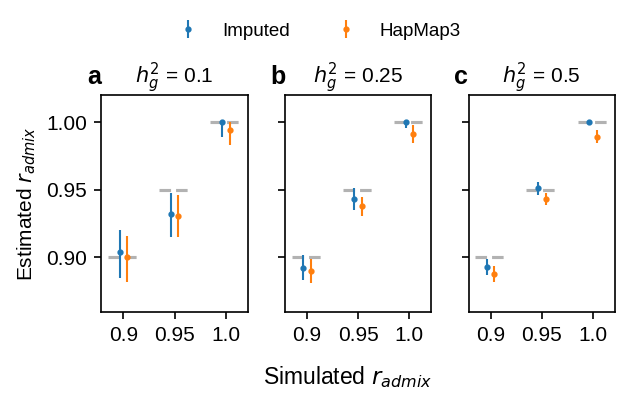

In [13]:
snpset_list = ["Imputed", "HapMap3"]
fig, axes = plt.subplots(figsize=(4.3, 2.2), dpi=150, ncols=3, sharey=True)
for i_hsq, hsq in enumerate([0.1, 0.25, 0.5]):
    for i_snpset, snpset in enumerate(["imputed", "hm3"]):
        df_tmp = df_plot[(df_plot.snpset == snpset) & (df_plot.hsq == hsq)]

        axes[i_hsq].errorbar(
            x=np.arange(len(df_tmp)) + (i_snpset - 0.5) * 0.15,
            y=df_tmp["mode"],
            yerr=(
                df_tmp["mode"] - df_tmp["lower_ci"],
                df_tmp["upper_ci"] - df_tmp["mode"],
            ),
            fmt=".",
            ms=4,
            mew=1,
            lw=1,
            label=snpset_list[i_snpset],
        )

    # box plots
    # x-axis
    axes[i_hsq].set_xticks([0, 1, 2])
    axes[i_hsq].set_xticklabels([0.9, 0.95, 1.0])

    # y-axis
    axes[i_hsq].set_ylim(0.86, 1.02)
    if i_hsq == 0:
        axes[i_hsq].set_ylabel("Estimated $r_{admix}$")

    # title
    axes[i_hsq].set_title(f"$h_g^2$ = {hsq}", fontsize=10)
    for i_cor, cor in enumerate([0.9, 0.95, 1.0]):
        axes[i_hsq].hlines(
            y=cor,
            xmin=i_cor - 0.3,
            xmax=i_cor + 0.3,
            color="gray",
            ls="--",
            alpha=0.6,
            zorder=-10,
        )
    # annotation
    axes[i_hsq].text(
        -0.1,
        1.05,
        string.ascii_lowercase[i_hsq],
        transform=axes[i_hsq].transAxes,
        size=12,
        weight="bold",
    )

fig.text(
    0.55,
    -0.05,
    "Simulated $r_{admix}$",
    fontsize=11,
    ha="center",
)

handles, labels = axes[0].get_legend_handles_labels()
# ph = [plt.plot([], marker="", ls="")[0]]  # Canvas
# handles = ph + handles
# labels = ["Simulated $h_g^2$:"] + labels  # Merging labels
fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.tight_layout()
fig.savefig("results/estimate-rg.pdf", bbox_inches="tight")

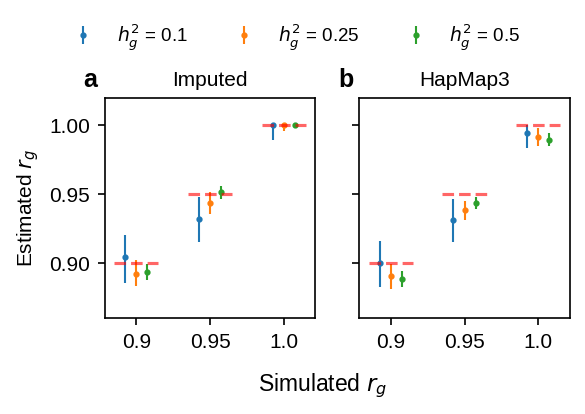

In [6]:
dict_title = {"hm3": "HapMap3", "imputed": "Imputed"}

fig, axes = plt.subplots(figsize=(4.0, 2.2), dpi=150, ncols=2, sharey=True)
for i_snpset, snpset in enumerate(["imputed", "hm3"]):
    # error bars
    for i_hsq, hsq in enumerate([0.1, 0.25, 0.5]):
        df_tmp = df_plot[(df_plot.snpset == snpset) & (df_plot.hsq == hsq)]

        axes[i_snpset].errorbar(
            x=np.arange(len(df_tmp)) + (i_hsq - 1) * 0.15,
            y=df_tmp["mode"],
            yerr=(
                df_tmp["mode"] - df_tmp["lower_ci"],
                df_tmp["upper_ci"] - df_tmp["mode"],
            ),
            fmt=".",
            ms=4,
            mew=1,
            lw=1,
            label=f"$h_g^2$ = {hsq}",
        )

    # box plots
    # x-axis
    axes[i_snpset].set_xticks([0, 1, 2])
    axes[i_snpset].set_xticklabels([0.9, 0.95, 1.0])

    # y-axis
    axes[i_snpset].set_ylim(0.86, 1.02)
    if i_snpset == 0:
        axes[i_snpset].set_ylabel("Estimated $r_g$")

    # title
    axes[i_snpset].set_title(dict_title[snpset], fontsize=10)
    for i_cor, cor in enumerate([0.9, 0.95, 1.0]):
        axes[i_snpset].hlines(
            y=cor,
            xmin=i_cor - 0.3,
            xmax=i_cor + 0.3,
            color="red",
            ls="--",
            alpha=0.6,
            zorder=10,
        )
    # annotation
    axes[i_snpset].text(
        -0.1,
        1.05,
        string.ascii_lowercase[i_snpset],
        transform=axes[i_snpset].transAxes,
        size=12,
        weight="bold",
    )

fig.text(
    0.55,
    -0.05,
    "Simulated $r_g$",
    fontsize=11,
    ha="center",
)

handles, labels = axes[0].get_legend_handles_labels()
# ph = [plt.plot([], marker="", ls="")[0]]  # Canvas
# handles = ph + handles
# labels = ["Simulated $h_g^2$:"] + labels  # Merging labels
fig.legend(
    handles,
    labels,
    ncol=6,
    loc="center",
    bbox_to_anchor=[0.5, 1.02],
    frameon=False,
    fontsize=9,
)

fig.tight_layout()
# fig.savefig("results/estimate-rg.pdf", bbox_inches="tight")

# Supp. tables

In [7]:
dict_loglik = dict_res["loglik"]
dict_pval = dict_res["pval"]

df_plot1 = []
df_plot2 = []

# fix pcausal / vary hsq
pcausal = 0.001
for hsq in [0.1, 0.25, 0.5]:
    for cor in [0.9, 0.95, 1.0]:
        for grm_prefix in ["hm3", "imputed"]:
            param = (
                f"hsq-{hsq}-pcausal-{np.format_float_positional(pcausal)}-cor-{cor}-hermodel-mafukb",
                f"{grm_prefix}.mafukb.005",
            )

            loglik = dict_loglik[param]
            mode = loglik.argmax() / 1000
            lower_ci, upper_ci = hdi(np.linspace(0, 1, 1001), loglik)
            prob_reject = np.mean(np.array(dict_pval[param]) < 0.05)
            df_plot1.append(
                [hsq, pcausal, cor, grm_prefix, mode, lower_ci, upper_ci, prob_reject]
            )

# fix hsq / vary pcausal
hsq = 0.25
for pcausal in [0.00001, 0.0001, 0.001, 0.01]:
    for cor in [0.9, 0.95, 1.0]:
        for grm_prefix in ["hm3", "imputed"]:
            param = (
                f"hsq-{hsq}-pcausal-{np.format_float_positional(pcausal)}-cor-{cor}-hermodel-mafukb",
                f"{grm_prefix}.mafukb.005",
            )
            loglik = dict_loglik[param]
            mode = loglik.argmax() / 1000
            lower_ci, upper_ci = hdi(np.linspace(0, 1, 1001), loglik)
            prob_reject = np.mean(np.array(dict_pval[param]) < 0.05)
            df_plot2.append(
                [hsq, pcausal, cor, grm_prefix, mode, lower_ci, upper_ci, prob_reject]
            )

df_plot1 = pd.DataFrame(
    df_plot1,
    columns=[
        "hsq",
        "pcausal",
        "cor",
        "snpset",
        "mode",
        "lower_ci",
        "upper_ci",
        "prob_reject",
    ],
)


df_plot2 = pd.DataFrame(
    df_plot2,
    columns=[
        "hsq",
        "pcausal",
        "cor",
        "snpset",
        "mode",
        "lower_ci",
        "upper_ci",
        "prob_reject",
    ],
)

df_plot1["ci"] = df_plot1.apply(
    lambda row: f"[{row.lower_ci:.3g}, {row.upper_ci:.3g}]", axis=1
)

df_plot2["ci"] = df_plot2.apply(
    lambda row: f"[{row.lower_ci:.3g}, {row.upper_ci:.3g}]", axis=1
)

In [8]:
df_display1 = (
    df_plot1.drop(columns=["pcausal", "lower_ci", "upper_ci"])[
        ["cor", "hsq", "snpset", "mode", "ci", "prob_reject"]
    ]
    .sort_values(["cor", "hsq", "snpset"])
    .rename(
        columns={
            "hsq": "$h_g^2$",
            "cor": "$r_g$",
            "snpset": "SNP set",
            "mode": "Mode",
            "ci": "95\% credible interval",
            "prob_reject": "$\text{Pr}[\text{reject } `r_g=1']$",
        }
    )
)
display(df_display1)
print(df_display1.to_latex(escape=False, index=False))

,$r_g$,$h_g^2$,SNP set,Mode,95\% credible interval,$\text{Pr}[\text{reject } `r_g=1']$
0,0.90,0.10,hm3,0.900,"[0.882, 0.916]",0.36
1,0.90,0.10,imputed,0.904,"[0.885, 0.92]",0.31
6,0.90,0.25,hm3,0.890,"[0.881, 0.899]",0.76
7,0.90,0.25,imputed,0.892,"[0.883, 0.902]",0.67
12,0.90,0.50,hm3,0.888,"[0.882, 0.894]",0.99
13,0.90,0.50,imputed,0.893,"[0.887, 0.899]",0.94
2,0.95,0.10,hm3,0.931,"[0.915, 0.946]",0.15
3,0.95,0.10,imputed,0.932,"[0.915, 0.948]",0.13
8,0.95,0.25,hm3,0.938,"[0.931, 0.945]",0.42
9,0.95,0.25,imputed,0.943,"[0.935, 0.951]",0.28


\begin{tabular}{rrlrlr}
\toprule
 $r_g$ &  $h_g^2$ & SNP set &  Mode & 95\% credible interval &  $\text{Pr}[\text{reject } `r_g=1']$ \\
\midrule
  0.90 &     0.10 &     hm3 & 0.900 &         [0.882, 0.916] &                                 0.36 \\
  0.90 &     0.10 & imputed & 0.904 &          [0.885, 0.92] &                                 0.31 \\
  0.90 &     0.25 &     hm3 & 0.890 &         [0.881, 0.899] &                                 0.76 \\
  0.90 &     0.25 & imputed & 0.892 &         [0.883, 0.902] &                                 0.67 \\
  0.90 &     0.50 &     hm3 & 0.888 &         [0.882, 0.894] &                                 0.99 \\
  0.90 &     0.50 & imputed & 0.893 &         [0.887, 0.899] &                                 0.94 \\
  0.95 &     0.10 &     hm3 & 0.931 &         [0.915, 0.946] &                                 0.15 \\
  0.95 &     0.10 & imputed & 0.932 &         [0.915, 0.948] &                                 0.13 \\
  0.95 &     0.25 &     hm3 & 0

In [9]:
df_display2 = (
    df_plot2.drop(columns=["hsq", "lower_ci", "upper_ci"])[
        ["cor", "pcausal", "snpset", "mode", "ci", "prob_reject"]
    ]
    .sort_values(["cor", "pcausal", "snpset"])
    .rename(
        columns={
            "pcausal": "$p_\text{causal}$",
            "cor": "$r_g$",
            "snpset": "SNP set",
            "mode": "Mode",
            "ci": "95\% credible interval",
            "prob_reject": "$\text{Pr}[\text{reject } `r_g=1']$",
        }
    )
)
df_display2["$p_\text{causal}$"] = df_display2["$p_\text{causal}$"].apply(
    lambda x: f"{x * 100:.1g}\%"
)
display(df_display2)
print(df_display2.to_latex(escape=False, index=False))

,$r_g$,$p_\text{causal}$,SNP set,Mode,95\% credible interval,$\text{Pr}[\text{reject } `r_g=1']$
0,0.90,0.001\%,hm3,0.909,"[0.9, 0.917]",0.61
1,0.90,0.001\%,imputed,0.911,"[0.901, 0.919]",0.57
6,0.90,0.01\%,hm3,0.900,"[0.891, 0.909]",0.74
7,0.90,0.01\%,imputed,0.903,"[0.893, 0.912]",0.59
12,0.90,0.1\%,hm3,0.890,"[0.881, 0.899]",0.76
13,0.90,0.1\%,imputed,0.892,"[0.883, 0.902]",0.67
18,0.90,1\%,hm3,0.902,"[0.893, 0.911]",0.66
19,0.90,1\%,imputed,0.904,"[0.894, 0.913]",0.59
2,0.95,0.001\%,hm3,0.923,"[0.915, 0.931]",0.52
3,0.95,0.001\%,imputed,0.930,"[0.921, 0.938]",0.43


\begin{tabular}{rllrlr}
\toprule
 $r_g$ & $p_\text{causal}$ & SNP set &  Mode & 95\% credible interval &  $\text{Pr}[\text{reject } `r_g=1']$ \\
\midrule
  0.90 &           0.001\% &     hm3 & 0.909 &           [0.9, 0.917] &                                 0.61 \\
  0.90 &           0.001\% & imputed & 0.911 &         [0.901, 0.919] &                                 0.57 \\
  0.90 &            0.01\% &     hm3 & 0.900 &         [0.891, 0.909] &                                 0.74 \\
  0.90 &            0.01\% & imputed & 0.903 &         [0.893, 0.912] &                                 0.59 \\
  0.90 &             0.1\% &     hm3 & 0.890 &         [0.881, 0.899] &                                 0.76 \\
  0.90 &             0.1\% & imputed & 0.892 &         [0.883, 0.902] &                                 0.67 \\
  0.90 &               1\% &     hm3 & 0.902 &         [0.893, 0.911] &                                 0.66 \\
  0.90 &               1\% & imputed & 0.904 &         [0.894,

# Main display table
Fixing p_causal = 0.1%, varying other parameters

# Numbers to cite in the manuscript

In [10]:
# # relative bias
# df_tmp = df_summary[df_summary.pcausal == 0.001]
# relative_bias = (df_tmp["estimated_ratio"]["mean"] - df_tmp["cor"]) / df_tmp["cor"]
# print(
#     f"Relative bias across 9 simulation settings (p_causal = 0.1%) is {np.mean(relative_bias * 100):.2f}%"
# )

# # standard errors
# df_tmp = df_summary[df_summary.pcausal == 0.001]
# relative_bias = (
#     df_tmp["estimated_ratio_stderr"]["mean"] - df_tmp["estimated_ratio"]["std"]
# ) / df_tmp["estimated_ratio"]["std"]
# print(
#     f"Relative bias of standard error across 9 simulation settings (p_causal = 0.1%) is {np.mean(relative_bias * 100):.2f}%"
# )

In [11]:
# for pcausal in df_summary.pcausal.unique():
#     print(f"--------pcausal={pcausal}--------")
#     # relative bias
#     df_tmp = df_summary[df_summary.pcausal == pcausal]
#     relative_bias = (df_tmp["estimated_ratio"]["mean"] - df_tmp["cor"]) / df_tmp["cor"]
#     print(
#         f"Relative bias across 9 simulation settings (p_causal = 0.1%) is {np.mean(relative_bias * 100):.2f}% ({np.std(relative_bias * 100):.2f}%)"
#     )

#     # standard errors
#     relative_bias = (
#         df_tmp["estimated_ratio_stderr"]["mean"] - df_tmp["estimated_ratio"]["std"]
#     ) / df_tmp["estimated_ratio"]["std"]
#     print(
#         f"Relative bias of standard error across 9 simulation settings (p_causal = 0.1%) is {np.mean(relative_bias * 100):.2f}% ({np.std(relative_bias * 100):.2f}%)"
#     )

#     # inflation under the null
#     pval = df_tmp.loc[df_tmp.cor == 1.0, "pval_lrt"]["<lambda>"]
#     print(
#         f"Relative bias of standard error across 9 simulation settings (p_causal = 0.1%) is {np.mean(pval):.2f} ({np.std(pval):.2f})"
#     )

In [12]:
# # format table
# df_tbl = pd.DataFrame(
#     {
#         "hsq": df_summary["hsq"],
#         "cor": df_summary["cor"],
#         "pcausal": df_summary["pcausal"].apply(
#             lambda x: f"{np.format_float_positional(x * 100)}\%"
#         ),
#         "estimate": df_summary["estimated_ratio"].apply(
#             lambda x: f"{x['mean']:.3f}$\pm${x['std']:.3f}", axis=1
#         ),
#         "estimated_stderr": df_summary["estimated_ratio_stderr"]["mean"]
#         .round(3)
#         .astype(str),
#         "pval_delta": df_summary["pval_delta"]["<lambda>"].round(3).astype(str),
#         "pval_lrt": df_summary["pval_lrt"]["<lambda>"].round(3).astype(str),
#     }
# )

# # main display table
# # hsq = 0.1, 0.25, 0.5; p_causal = 0.1%
# df_main = (
#     df_tbl[(df_tbl.hsq == 0.25)]
#     .drop(columns=["hsq", "pval_delta"])
#     .rename(
#         columns={
#             "cor": "$r_g$",
#             "pcausal": "$p_\text{causal}$",
#             "estimate": "$\widehat{r_g}$",
#             "estimated_stderr": "$\widehat{\text{s.e.}(r_g)}$",
#             "pval_lrt": "$\text{Pr}[\text{reject } `r_g=1']$",
#         }
#     )
# )

# # exchange columns, such that, column 1: p_causal, column 2: rg
# df_main = df_main[
#     [df_main.columns[1], df_main.columns[0]] + df_main.columns[2:].tolist()
# ]
# print(df_main.to_latex(escape=False, index=False))